## Introduction

### Overview
We plan to conduct a sentiment analysis of Yelp text reviews posted by users of the
platform. We will be using a Kaggle dataset that provides business, review, and user
data for 11 major metropolitan areas. Included in the main dataset are over 5.2 million
user reviews and 174,000 businesses. The data consists of reviews posted by users in
different cities in the US from 2010 to 2018, and we intend to analyze, visualize and
ascertain the change in the language being used within reviews over a period of time.
In order to achieve this goal, we plan to use libraries like nltk, wordcloud, seaborn,
TextBlob, etc. along the way. It is our aim to complete the whole project by defining
functions, that can help us reuse code (and also help make the package more
interactive and responsive to user inputs) that will perform similar tasks. The code thus
produced will be well commented, and explain the steps being followed along the
entire process in the form of a Jupyter Notebook.

https://drive.google.com/open?id=1-I4L0tQArFR6xpxumw2Sj2ecIsyd6InF

https://drive.google.com/open?id=1yYhCv7ewMxqS0l6rcr8F8drIpIT2Du9O


### Scope
This project helps us apply all of the techniques and methodologies we have learnt
during this quarter in IMT 511. We get to tackle difficult datasets, learn new libraries
(how to apply and why to apply them to our problem). IMT 511 being a course intended
to ready us for Data Science projects and work, we consider this project a stepping
stone to a hands-on experience in performing complex data manipulation tasks,
constructing clean and helpful visualizations that tell a story about the data being
looked at.
The difficulties we expect to face while doing this project are mainly related to readying
the data present in our dataset for analysis purposes, and in figuring out the right
way(s) to visualize and present our findings in the final submission. Not to mention, the
dataset we plan to analyze is quite large in size (3.5+ GB), and in the CSV notation - this
presents another challenge akin to what we will face when working for organizations
post graduation.

### Feedback from Prof. Joel Ross

This sounds like a fine project. Note that you'll need to have pretty substantial analysis for a 3 person project (but I'm sure you can do that).

You'll also need to figure out some way to make sure the data is available and can submitted with your project--you can't upload a 3.5gp file to GitHub (and I won't be able to download that to test and check your work!)

In [1]:
# import required libraries for analysis

import pandas as pd
import os.path as path
from datetime import datetime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# suppress any warnings for a clean notebook display (warnings are obstructive)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# import supporting files that have information surrounding our analysis

business = pd.read_csv('yelp_business.csv')

In [4]:
# since the reviews file is too large to import as a pandas dataframe (throws Memory Error)
# we circumvent that problem by reading the CSV sequentially and loading it into an SQLite database 
# below code imports the database file if it exists, else creates a database file from the CSV containing reviews data

if (path.isfile('csv_database.db')):
    import sqlite3 as db
    csv_database = db.connect('csv_database.db')
else:
    from sqlalchemy import create_engine
    file = 'yelp_review.csv'
    # print(pd.read_csv(file, nrows=5))
    csv_database = create_engine('sqlite:///csv_database.db')
    chunksize = 100000
    i = 0; j = 1
    for df in pd.read_csv(file, chunksize=chunksize, iterator=True, encoding='utf-8'):
        df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
        df.index += j
        i+=1
        df.to_sql('reviews', csv_database, if_exists='append')
        j = df.index[-1] + 1

In [5]:
# check the columns present in the reviews file

print(pd.read_sql_query('SELECT sql FROM sqlite_master WHERE name="reviews"', csv_database)['sql'].iloc[0])

CREATE TABLE reviews (
	"index" BIGINT, 
	review_id TEXT, 
	user_id TEXT, 
	business_id TEXT, 
	stars BIGINT, 
	date TEXT, 
	text TEXT, 
	useful BIGINT, 
	funny BIGINT, 
	cool BIGINT
)


In [6]:
# look for the businesses that garner most reviews

top_5_businesses = pd.read_sql_query('SELECT business_id FROM (SELECT business_id, count(text) FROM reviews GROUP BY business_id ORDER BY count(text) DESC LIMIT 5)', csv_database)

In [7]:
# business ids for the top 5

top_5_businesses

,business_id
0,4JNXUYY8wbaaDmk3BPzlWw
1,RESDUcs7fIiihp38-d6_6g
2,K7lWdNUhCbcnEvI0NhGewg
3,cYwJA2A6I12KNkm2rtXd5g
4,DkYS3arLOhA8si5uUEmHOw


In [8]:
# fetch additional details for these businesses

business_name = []
business_city = []
business_state = []
for b_ness in top_5_businesses.iterrows():
    b_ness = b_ness[1].tolist()[0]
    business_name.append(business[business['business_id'] == b_ness]['name'].tolist()[0])
    business_city.append(business[business['business_id'] == b_ness]['city'].tolist()[0])
    business_state.append(business[business['business_id'] == b_ness]['state'].tolist()[0])
top_5_businesses['name'] = business_name
top_5_businesses['city'] = business_city
top_5_businesses['state'] = business_state

In [9]:
top_5_businesses

,business_id,name,city,state
0,4JNXUYY8wbaaDmk3BPzlWw,"""Mon Ami Gabi""",Las Vegas,NV
1,RESDUcs7fIiihp38-d6_6g,"""Bacchanal Buffet""",Las Vegas,NV
2,K7lWdNUhCbcnEvI0NhGewg,"""Wicked Spoon""",Las Vegas,NV
3,cYwJA2A6I12KNkm2rtXd5g,"""Gordon Ramsay BurGR""",Las Vegas,NV
4,DkYS3arLOhA8si5uUEmHOw,"""Earl of Sandwich""",Las Vegas,NV


*As we can see here, all of the frequently reviewed businesses in this dataset are situated in Las Vegas (NV)*

Text(0, 0.5, 'Star rating')

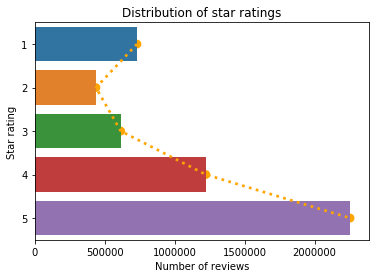

In [10]:
# we analyze the distribution of star ratings across all of the businesses in this dataset

dist_of_star_ratings = pd.read_sql_query('SELECT stars, count(business_id) FROM reviews GROUP BY stars ORDER BY count(business_id) DESC', csv_database)


# plot the visualization to see our distibution

sns.barplot(y='stars', x='count(business_id)', data=dist_of_star_ratings, orient='horizontal').set_title('Distribution of star ratings')
sns.pointplot(y='stars', x='count(business_id)', data=dist_of_star_ratings, orient='horizontal', linestyles='dotted', color='orange')
plt.xlabel("Number of reviews")
plt.ylabel("Star rating")

Text(0, 0.5, 'Star rating')

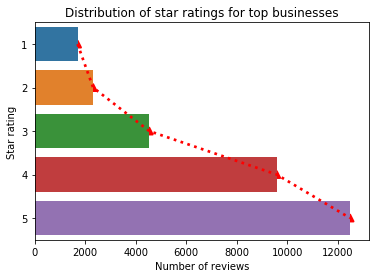

In [11]:
# let's contrast that with the distribution of ratings for our top 5 businesses

most_reviewed_business = pd.read_sql_query('SELECT stars, count(business_id) FROM reviews WHERE business_id IN ("4JNXUYY8wbaaDmk3BPzlWw", "RESDUcs7fIiihp38-d6_6g", "K7lWdNUhCbcnEvI0NhGewg", "cYwJA2A6I12KNkm2rtXd5g", "DkYS3arLOhA8si5uUEmHOw") GROUP BY stars ORDER BY count(business_id) DESC', csv_database)


# plot the visualization to see our distibution

sns.barplot(y='stars', x='count(business_id)', data=most_reviewed_business, orient='horizontal').set_title('Distribution of star ratings for top businesses')
sns.pointplot(y='stars', x='count(business_id)', data=most_reviewed_business, orient='horizontal', linestyles='dotted', color='red', markers='^')
plt.xlabel("Number of reviews")
plt.ylabel("Star rating")

*Evidently, the distributions are markedly different!*
- We can observe that the highly reviewed businesses receive higher reviews in general (most raters give a 5, few give 4, fewer rate 3 and so on).
- Since these businesses are doing well (seemingly!), we should go ahead and deep dive into the reviews posted for them.

In [10]:
# we pull review data for the top businesses for further analysis

data_for_top_restaurants = pd.read_sql_query('SELECT * FROM reviews WHERE business_id IN ("4JNXUYY8wbaaDmk3BPzlWw", "RESDUcs7fIiihp38-d6_6g", "K7lWdNUhCbcnEvI0NhGewg", "cYwJA2A6I12KNkm2rtXd5g", "DkYS3arLOhA8si5uUEmHOw")', csv_database)

In [11]:
# we check the number of reviews these businesses have in total

print(data_for_top_restaurants.shape[0])

30637


*Now, we move on to check whether ratings have been rising or falling for each of our top businesses -*

In [37]:
# define functions for preprocessing, data manipulation, etc.

# add/modify information for analysis
def modify_for_analysis(restaurant):
    date = []; year = []; month = []; day = []
    for i in restaurant.date.tolist():
        date_of_review = str(i).split('-')
        date.append(datetime.strptime(i, '%Y-%m-%d'))
        year.append(date_of_review[0])
        month.append(date_of_review[1])
        day.append(date_of_review[2])
    restaurant['date'] = date
    restaurant['year'] = year
    restaurant['month'] = month
    restaurant['day'] = day
    return restaurant


# plot the change in ratings over years for a restaurant/business
def mean_ratings_over_time(restaurant, color):
    ratings_over_time = restaurant.groupby('year')['stars'].mean()
    years = ratings_over_time.index
    mean_ratings = ratings_over_time.values
    sns.pointplot(x=years, y=mean_ratings, color=color).set_title('Mean ratings across years')
    plt.ylim(0,5)
    plt.xlabel('Year')
    plt.ylabel('Rating (on a scale of 1 to 5)')

# plot the variation in number of reviews over years    
def yearly_number_of_reviews(restaurant,year,color):
    yearly_filtered_data = restaurant[restaurant['year'] == year]
    reviews_over_time = yearly_filtered_data.groupby(['month']).size()
    months=reviews_over_time.index
    #print(months)
    NOR=reviews_over_time.values
    #print(reviews)
    sns.pointplot(x=months, y=NOR,color=color).set_title('Reviews in the year')
    plt.ylim(0,200)
    plt.xlabel('Months')
    plt.ylabel('Number of reviews')

    
# function to create wordcloud and visualize
def wordcloud(restaurant):
    #total number of words in all the reviews of a restaurant
    text = " ".join(review for review in restaurant.text)
    print ("There are {} words in the combination of all reviews for this restaurant.".format(len(text)))
    # Create stopword list:
    stopwords = set(STOPWORDS)
    # Generate a word cloud image
    wordcloud = WordCloud(width = 4000, height = 2000,stopwords=stopwords, background_color="white").generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [15]:
# we split the data into specific dataframes for each business/restaurant - this will help us analyze each of them individually

# 4JNXUYY8wbaaDmk3BPzlWw : Mon Ami Gabi
restaurant_1 = data_for_top_restaurants[data_for_top_restaurants['business_id'] == '4JNXUYY8wbaaDmk3BPzlWw']
restaurant_1 = modify_for_analysis(restaurant_1)

# RESDUcs7fIiihp38-d6_6g : Bacchanal Buffet
restaurant_2 = data_for_top_restaurants[data_for_top_restaurants['business_id'] == 'RESDUcs7fIiihp38-d6_6g']
restaurant_2 = modify_for_analysis(restaurant_2)

# K7lWdNUhCbcnEvI0NhGewg : Wicked Spoon
restaurant_3 = data_for_top_restaurants[data_for_top_restaurants['business_id'] == 'K7lWdNUhCbcnEvI0NhGewg']
restaurant_3 = modify_for_analysis(restaurant_3)

# cYwJA2A6I12KNkm2rtXd5g : Gordon Ramsay BurGR
restaurant_4 = data_for_top_restaurants[data_for_top_restaurants['business_id'] == 'cYwJA2A6I12KNkm2rtXd5g']
restaurant_4 = modify_for_analysis(restaurant_4)

# DkYS3arLOhA8si5uUEmHOw : Earl of Sandwich
restaurant_5 = data_for_top_restaurants[data_for_top_restaurants['business_id'] == 'DkYS3arLOhA8si5uUEmHOw']
restaurant_5 = modify_for_analysis(restaurant_5)

*Going forward, we analyze the characteristics for each restaurant -*

## Mon Ami Gabi

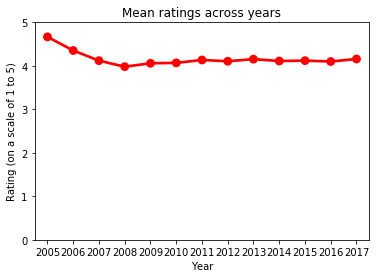

In [16]:
mean_ratings_over_time(restaurant_1, 'red')

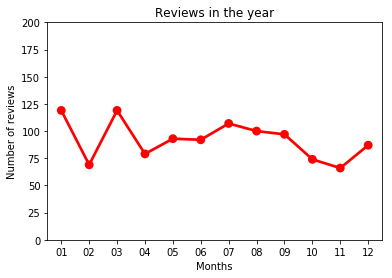

In [38]:
yearly_number_of_reviews(restaurant_1,'2014','red')

There are 4746563 words in the combination of all reviews for this restaurant.


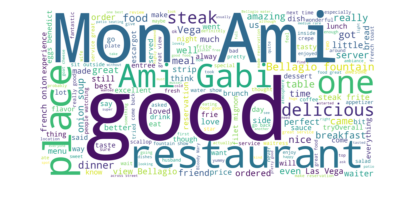

In [19]:
restaurant_1 = restaurant_1.reset_index(drop=True)
wordcloud(restaurant_1)

## Bacchanal Buffet

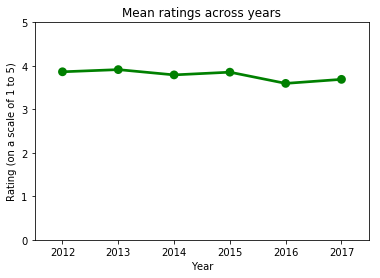

In [17]:
mean_ratings_over_time(restaurant_2, 'green')

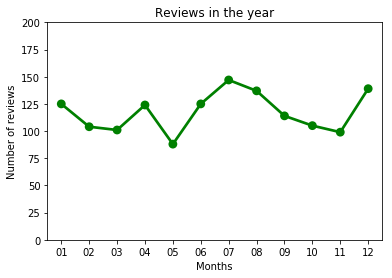

In [39]:
yearly_number_of_reviews(restaurant_2,'2015','green')

There are 5803713 words in the combination of all reviews for this restaurant.


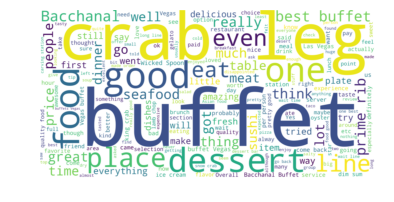

In [20]:
restaurant_2 = restaurant_2.reset_index(drop=True)
wordcloud(restaurant_2)

## Wicked Spoon

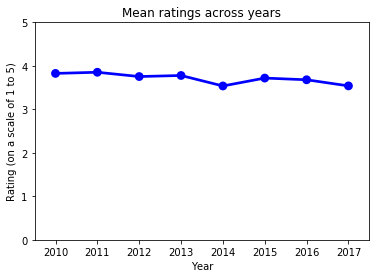

In [18]:
mean_ratings_over_time(restaurant_3, 'blue')

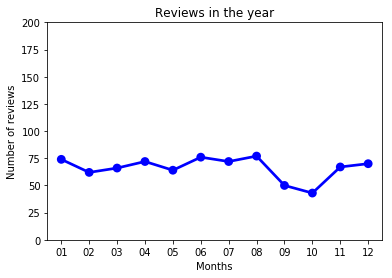

In [40]:
yearly_number_of_reviews(restaurant_3,'2015','blue')

There are 4581074 words in the combination of all reviews for this restaurant.


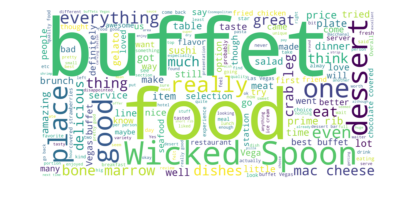

In [21]:
restaurant_3 = restaurant_3.reset_index(drop=True)
wordcloud(restaurant_3)

## Gordon Ramsay BurGR

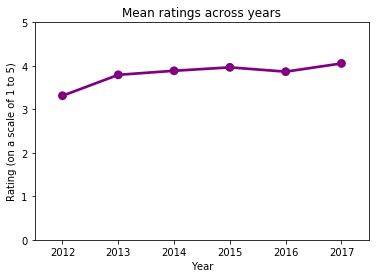

In [19]:
mean_ratings_over_time(restaurant_4, 'purple')

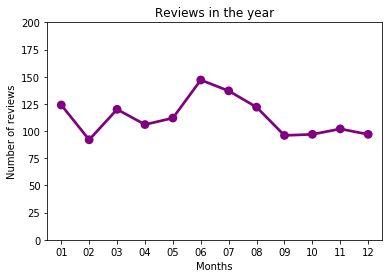

In [41]:
yearly_number_of_reviews(restaurant_4,'2015','purple')

There are 3943609 words in the combination of all reviews for this restaurant.


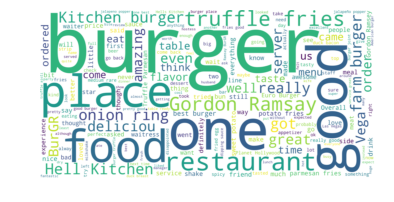

In [22]:
restaurant_4 = restaurant_4.reset_index(drop=True)
wordcloud(restaurant_4)

## Earl of Sandwich

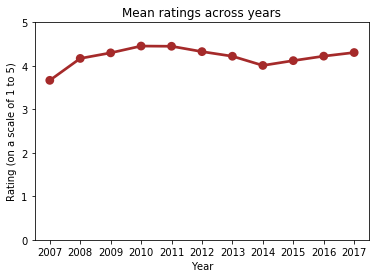

In [20]:
mean_ratings_over_time(restaurant_5, 'brown')

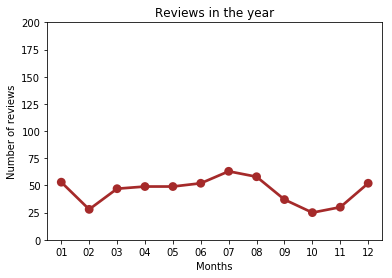

In [42]:
yearly_number_of_reviews(restaurant_5,'2015','brown')

There are 2535708 words in the combination of all reviews for this restaurant.


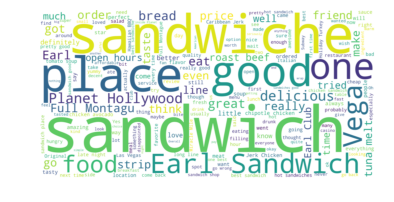

In [23]:
restaurant_5 = restaurant_5.reset_index(drop=True)
wordcloud(restaurant_5)

## Observations from wordclouds of top restaurants!

*As we can see from the wordclouds of the top 5 restaurants in Las Vegas, the most common occuring words are 'good' and 'food'. It's not a surprise considering these 5 restaurants are the top 5 restaurants in Las Vegas.*


We can find insights about the restaurants by analyzing the wordclouds 
- We can see that crab dishes are really popular at the Bacchanal Buffet. 
- Farm burger seems to be a fan favorite at the Gordon Ramsay BurGR. 
- Buffets are the specialty at Wicked Spoon and Bacchanal Buffet.

## Sentiment Analysis and Prediction of Review Ratings on the Yelp Reviews Dataset using various Machine Learning Algorithms

In this section, we will build a machine learning algorithm called Multilayer Perceptron Classifier to predict the  star rating of the reviews of the top 5 restaurants in Las Vegas.

In [25]:
# IMPORTING ALL THE NECESSARY LIBRARIES AND PACKAGES
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV

In [24]:
#combine the data of the top 5 restaurants in Las Vegas
data = pd.concat([restaurant_1, restaurant_2,restaurant_3,restaurant_4,restaurant_5], ignore_index=True)

# SHAPE OF THE DATASET
print("Shape of the dataset:")
print(data.shape)
# COLUMN NAMES
print("Column names:")
print(data.columns)
# DATATYPE OF EACH COLUMN
print("Datatype of each column:")
print(data.dtypes)

Shape of the dataset:
(30637, 13)
Column names:
Index(['index', 'review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'year', 'month', 'day'],
      dtype='object')
Datatype of each column:
index                   int64
review_id              object
user_id                object
business_id            object
stars                   int64
date           datetime64[ns]
text                   object
useful                  int64
funny                   int64
cool                    int64
year                   object
month                  object
day                    object
dtype: object


In [26]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
data['length'] = data['text'].apply(len)
data.head()

,index,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year,month,day,length
0,1721,YCzBgTYCyTtPAe2v8_GGKA,CZs1Eq7t1fqpXV1yox-CVg,4JNXUYY8wbaaDmk3BPzlWw,4,2017-10-25,Traditional French fare at the heart of the La...,0,0,1,2017,10,25,770
1,2400,lPf1wwTu9VeWABHDPhu2tA,Zqk-ye_OHeH_sS1JsdsLgg,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-15,"This is my go to place for the last 12 years, ...",4,0,2,2013,10,15,622
2,3431,voVb586hGvZC6vUA7HUIIw,RmThjWcv7x5Z_vVuOlRNwQ,4JNXUYY8wbaaDmk3BPzlWw,2,2017-04-03,"Mediocre food for too much money, at least at ...",0,0,0,2017,04,03,94
3,7922,jipTZe7L20v422d2Di2_Tw,hBl_w9Rmn_Bz0HiMzwaknA,4JNXUYY8wbaaDmk3BPzlWw,4,2012-12-26,My family and I had dinner here and the wait w...,0,0,0,2012,12,26,1198
4,8794,D5r-QLswHpnxaMadQdi_dg,eZ5I1bHkdXoGOFKn_oOFFQ,4JNXUYY8wbaaDmk3BPzlWw,5,2015-10-21,Patio dining at its best. Steak au poive with ...,0,0,0,2015,10,21,244


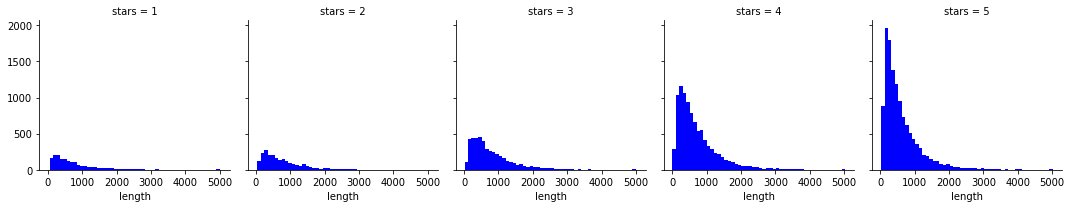

In [27]:
#Let us now visualize the if there is any correlation between stars and the length of the review.
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [28]:
#There are 3 voting columns for the reviews - funny, cool and useful. Let us now find the mean values with respect to the stars given to the review
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = data.groupby('stars').mean()
stval

,index,useful,funny,cool,length
stars,,,,,
1,5.001886e+07,0.964747,0.570505,0.284959,778.555229
2,4.790156e+07,1.151424,0.658758,0.500000,819.589733
3,4.859048e+07,1.257048,0.644493,0.735903,810.242731
4,4.866197e+07,1.178575,0.609888,0.794409,728.533848
5,4.834795e+07,1.057086,0.556045,0.723939,615.866213


In [29]:
#Let us now see what the correlation is between the three voting columns.
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()

,index,useful,funny,cool,length
index,1.000000,-0.626752,-0.533584,-0.596221,0.089085
useful,-0.626752,1.000000,0.779384,0.706004,0.349742
funny,-0.533584,0.779384,1.000000,0.147881,0.777119
cool,-0.596221,0.706004,0.147881,1.000000,-0.403935
length,0.089085,0.349742,0.777119,-0.403935,1.000000


There is a positive correlation between:

* Funny and Useful    
* Funny and Length
* Useful and Length  

Thus, we can say that longer reviews tend to be funny and useful.

In [30]:
#Classifying the dataset and splitting it into the reviews and stars
# CLASSIFICATION
data_classes = data[(data['stars']==1) | (data['stars']==3) | (data['stars']==5)]
data_classes.head()
print(data_classes.shape)

# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['stars']
print(x.head())
print(y.head())

(18732, 14)
1    This is my go to place for the last 12 years, ...
4    Patio dining at its best. Steak au poive with ...
6    This review is long overdue.  I have a meal at...
7    My wife and I loved it.  It was a date night f...
8    Had lunch at Mon Ami Gabi on a Friday afternoo...
Name: text, dtype: object
1    5
4    5
6    5
7    5
8    3
Name: stars, dtype: int64


In [31]:
#Data_Cleaning
#We will now, define a function which will clean the dataset by removing stopwords and punctuations
# CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

#Vectorization
#We will now vectorize a single review and see the results
# CONVERTING THE WORDS INTO A VECTOR
vocab = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
x = x.reset_index(drop=True)
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)

print("Getting the words back:")
print(vocab.get_feature_names()[19648])
print(vocab.get_feature_names()[10643])

43142
This is my go to place for the last 12 years, consistent with their dishes and amazing wine selection.For my large groups of 150 or more to my family dinners consisting of 6 ppl, the food tastes exactly the same. Great prices for a strip restaurant. must have appitizer Liver Mousse Pate, and steak bordelaise is my favorite. When it's a diet free day I'll ask for roquefort sauce for my pomme frittes. Best dish on their Plats Du Jour is the Beef Wellington. (Was on Thursdays, now on Sundays) 

TIP-
**If you haven't tried the Shrimp Gabi appitizer, you can still order it. Even though its been off the menu for years***
  (0, 231)	1
  (0, 366)	1
  (0, 1451)	1
  (0, 2980)	1
  (0, 3058)	1
  (0, 5067)	1
  (0, 5419)	1
  (0, 6175)	1
  (0, 6446)	1
  (0, 7151)	1
  (0, 7476)	1
  (0, 7985)	1
  (0, 8837)	1
  (0, 9747)	1
  (0, 9935)	1
  (0, 11425)	1
  (0, 11970)	1
  (0, 12105)	1
  (0, 12383)	1
  (0, 13291)	1
  (0, 14418)	1
  (0, 14757)	2
  (0, 14971)	1
  (0, 16434)	1
  (0, 19052)	1
  :	:
  (0, 2

In [32]:
#Vectorization of the whole review set and and checking the sparse matrix
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (18732, 43142)
Non-Zero occurences:  1053469
Density of the matrix =  0.13035789433961867


In [33]:
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

In [34]:
#Modeling
#We will now use multiple Machine Algorithms to see which gives the best performance
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 203   96   41]
 [  70  663  210]
 [  18  145 2301]]
Score: 84.52
Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.60      0.64       340
           3       0.73      0.70      0.72       943
           5       0.90      0.93      0.92      2464

   micro avg       0.85      0.85      0.85      3747
   macro avg       0.78      0.74      0.76      3747
weighted avg       0.84      0.85      0.84      3747



The Multilayer Perceptron algorithm's prediction accuracy is 84.73%.

In [35]:
#Predicting for a random review
#Since multilayer perceptron classifier has the best score
#let us use it to predict a random positive review, a random average review and a random negative review!
pr = data['text'][0]
print(pr)
print("Actual Rating: ",data['stars'][0])
pr_t = vocab.transform([pr])
print("Predicted Rating:",mlp.predict(pr_t)[0])

Traditional French fare at the heart of the Las Vegas Strip that never fails to satisfy.  Whether you're a regular or virgin at Mon Ami Gabi please make sure you save room for dessert.  Perhaps do what I've done, just make the dining experience a dessert filled table;)  made from scratch and sinfully delicious desserts.  Yes, I have a sweet tooth- have you not seen my pictures!  
I've dined here numerous times over the years, yes Food and not only dessert.  
Onion soup, steak frites and those mussels mariniere! The mussels, I have will power and have the half order. Yes, half so I can clearly utilize that doughy stuff by scooping up the white wine & herbs broth:) 
You can't go wrong with pretty much anything the menu offers, so peruse that menu and order away!
Actual Rating:  4
Predicted Rating: 5


In [36]:
#another example
pr = data['text'][18]
print(pr)
print("Actual Rating: ",data['stars'][18])
pr_t = vocab.transform([pr])
print("Predicted Rating:",mlp.predict(pr_t)[0])

Fabulous place, increíble food, and our server Megan was simply amazing, super nice, friendly and helpful!!!
Actual Rating:  5
Predicted Rating: 5
